In [144]:
import pandas as pd

# get the data and print the head
df = pd.read_excel("COVID_BRAZIL.xlsx")
df.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,FgMetro
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125,1,0,0,0,NaN,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125,1,0,0,0,NaN,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125,2,1,0,0,NaN,NaN,NaN


In [81]:
df

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125,0,0,0,0,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125,1,1,0,0,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125,1,0,0,0,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125,1,0,0,0,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125,2,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413051,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2020-06-14,25,3015268,22871,912,304,11,NaN,NaN
413052,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2020-06-15,25,3015268,23684,813,319,15,NaN,NaN
413053,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2020-06-16,25,3015268,25380,1696,348,29,NaN,NaN
413054,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2020-06-17,25,3015268,27140,1760,365,17,NaN,NaN


In [145]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# constants
TESTING_DAYS = 16 # how many days that will be used to verify the accuracy of the data

# metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_square_error(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def run_analysis(actual, predicted, state, test_type):
        # MAPE:
        mape = mean_absolute_percentage_error(actual, predicted)
        # MAD
        mad = mean_absolute_error(actual, predicted)
        # RMSE
        rmse = root_mean_square_error(actual, predicted)
        
        results = {"MAPE": mape, "MAD": mad, "RMSE": rmse, "State": state, "Test Type": test_type}
        results_series = pd.Series(results)
        
        return results_series
    
def clean_data(df, state):
        if state == "BRAZIL": # takes care of the case of analyzing Brazil rather than a single state
            df1 = df[df["estado"].isnull()] 
        else:
            df1 = df.query("(municipio != municipio) and (estado == '%s')" % state)
            
        # removes bad data
        prev_row = 0
        for index, row in df1.iterrows():
            if (row["casosAcumulado"] < prev_row): # accumulated cases cannot decrease
                df1 = df1.drop(index, axis = 0 )
            else:
                prev_row = row["casosAcumulado"]
        return df1


In [149]:
from pmdarima import auto_arima

def run_test(df, state):
    clean_df = clean_data(df, state)
    train, test = clean_df.iloc[:len(clean_df) - TESTING_DAYS, [7, 10]], clean_df.iloc[len(clean_df) - TESTING_DAYS:, [7,10]]
    train= train[train['casosAcumulado'] != 0]
    arima_model = auto_arima(np.asarray(train['casosAcumulado']), trace=True, error_action='ignore', suppress_warnings=True)
    forecast = arima_model.predict(n_periods=len(test))
    
    # generate plot
    plt.figure(figsize=(16,8))
    plt.plot(train["data"], train['casosAcumulado'], label='Train')
    plt.plot(test["data"], test['casosAcumulado'], label='Actual Data')
    plt.plot(test["data"], forecast, label='ARIMA Prediction')
    plt.legend(loc='best')
    plt.suptitle(state + " Graph")
    plt.savefig("ARIMA Results\plots\%s graph.png" % state)
    plt.show()
    
    # create results
    results_df = pd.DataFrame()
    results_series = (run_analysis(test["casosAcumulado"], forecast, state, "ARIMA"))
    results_series["order"] = (arima_model.get_params()["order"])
    results_df = results_df.append(results_series, ignore_index = True)
    return results_df

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1002.987, BIC=1017.572, Time=0.468 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1036.470, BIC=1041.332, Time=0.017 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1001.565, BIC=1008.858, Time=0.071 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1000.715, BIC=1008.007, Time=0.107 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1034.690, BIC=1037.121, Time=0.019 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1001.162, BIC=1010.885, Time=0.192 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1001.801, BIC=1011.525, Time=0.209 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1001.167, BIC=1013.321, Time=0.277 seconds
Total fit time: 1.405 seconds


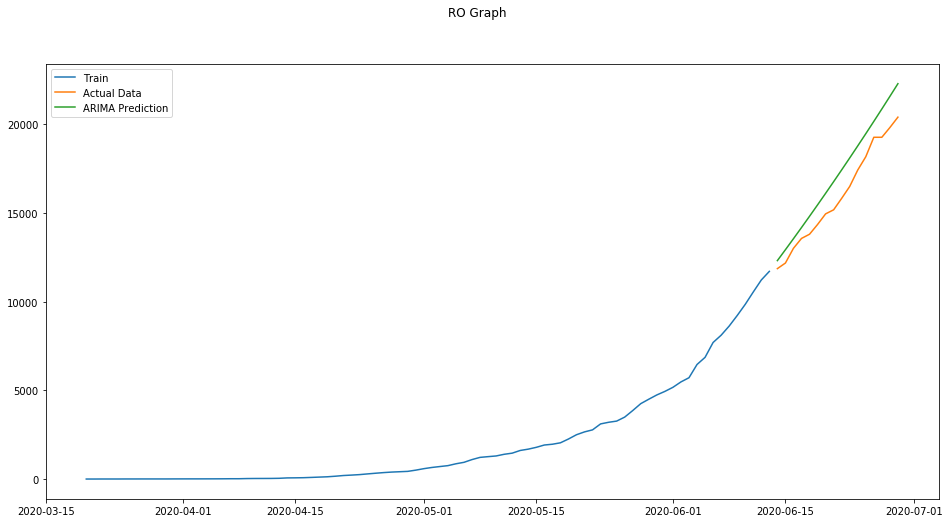

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=965.163, BIC=979.819, Time=0.317 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=986.682, BIC=991.568, Time=0.016 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=962.099, BIC=969.427, Time=0.072 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=961.472, BIC=968.800, Time=0.129 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=984.788, BIC=987.231, Time=0.015 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=961.481, BIC=971.251, Time=0.107 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=961.277, BIC=971.047, Time=0.168 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=963.273, BIC=975.486, Time=0.343 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=963.271, BIC=975.484, Time=0.248 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=962.342, BIC=976.998, Time=0.404 seconds
Near non-invertible roots for order (1, 2, 3)(0, 0, 0, 0

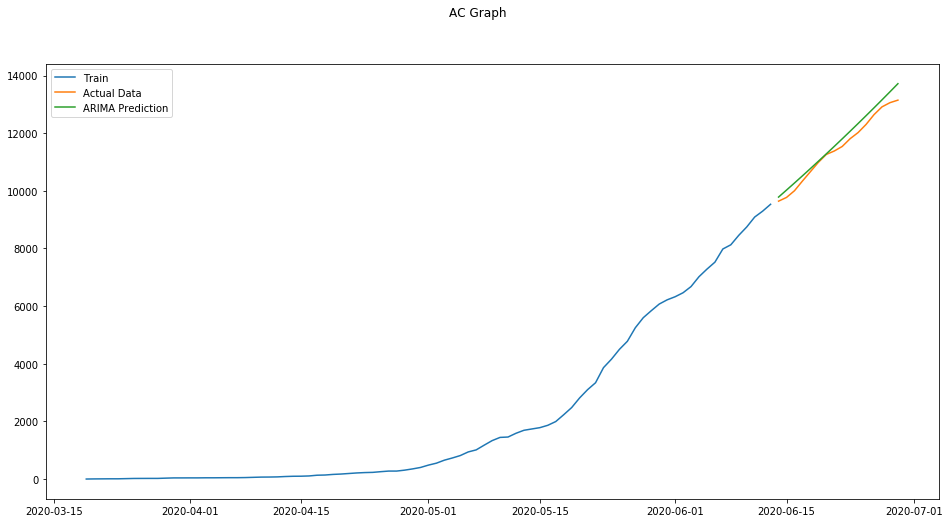

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1307.504, BIC=1322.436, Time=0.390 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1319.904, BIC=1324.881, Time=0.018 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1321.172, BIC=1328.638, Time=0.033 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1320.145, BIC=1327.611, Time=0.133 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1317.965, BIC=1320.454, Time=0.017 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1305.167, BIC=1317.610, Time=0.393 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1304.975, BIC=1314.930, Time=0.220 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=1303.203, BIC=1315.646, Time=0.417 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=1305.409, BIC=1320.341, Time=0.465 seconds
Fit ARIMA(0,2,4)x(0,0,0,0) [intercept=True]; AIC=1304.889, BIC=1319.821, Time=0.516 seconds
Fit ARIMA(1,2,4)x(0,0,0,0) [intercep

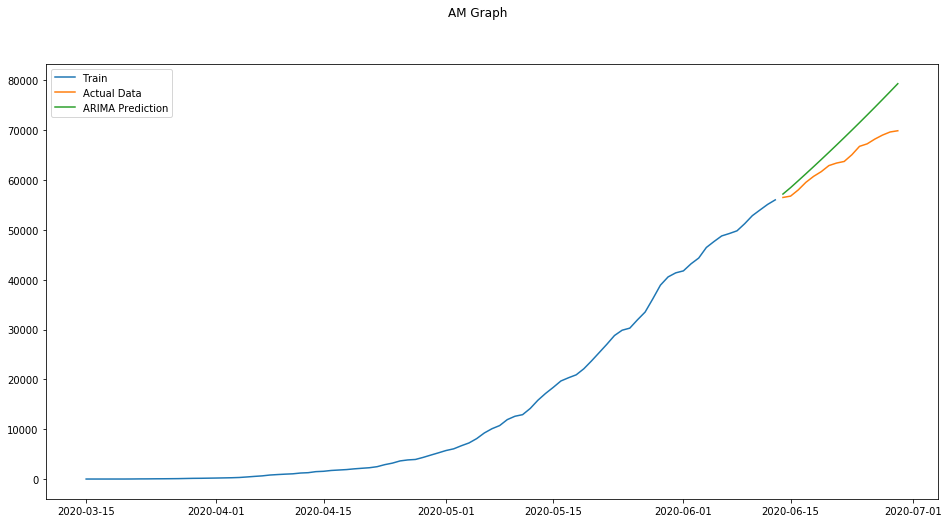

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=854.067, BIC=868.508, Time=0.812 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=859.930, BIC=864.743, Time=0.020 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=854.715, BIC=861.935, Time=0.089 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=853.622, BIC=860.842, Time=0.087 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=858.033, BIC=860.440, Time=0.016 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=855.338, BIC=864.965, Time=0.140 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=855.436, BIC=865.063, Time=0.124 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=853.616, BIC=865.649, Time=0.360 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 1.660 seconds


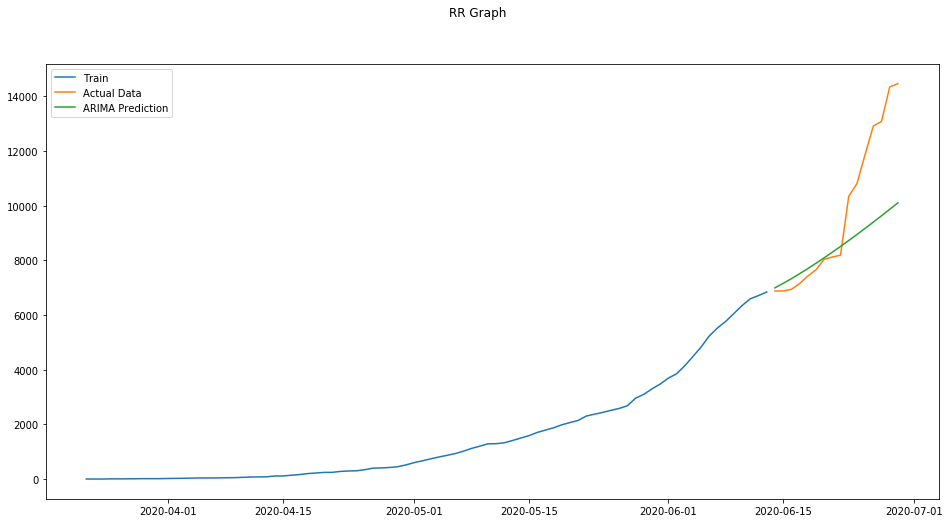

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1269.648, BIC=1284.304, Time=0.454 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1303.687, BIC=1308.573, Time=0.014 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1305.616, BIC=1312.944, Time=0.029 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1305.570, BIC=1312.898, Time=0.113 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1301.906, BIC=1304.348, Time=0.014 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1288.621, BIC=1300.834, Time=0.380 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1281.171, BIC=1293.385, Time=0.342 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1269.234, BIC=1286.333, Time=0.470 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1272.186, BIC=1286.842, Time=0.387 seconds
Fit ARIMA(4,2,2)x(0,0,0,0) [intercept=True]; AIC=1275.674, BIC=1295.215, Time=0.480 seconds
Near non-invertible roots for order 

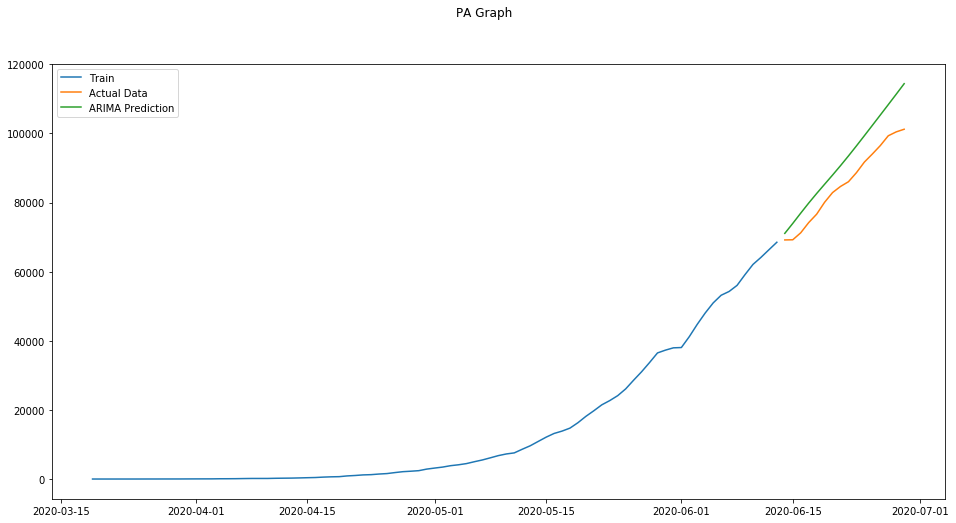

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1055.302, BIC=1069.887, Time=0.443 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1089.610, BIC=1094.472, Time=0.013 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1078.164, BIC=1085.456, Time=0.074 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1053.304, BIC=1060.597, Time=0.104 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1087.813, BIC=1090.243, Time=0.014 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1054.684, BIC=1064.407, Time=0.194 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1054.486, BIC=1064.210, Time=0.233 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1053.304, BIC=1065.458, Time=0.405 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=1062.397, BIC=1076.982, Time=0.576 seconds
Near non-invertible roots for order (1, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the bord

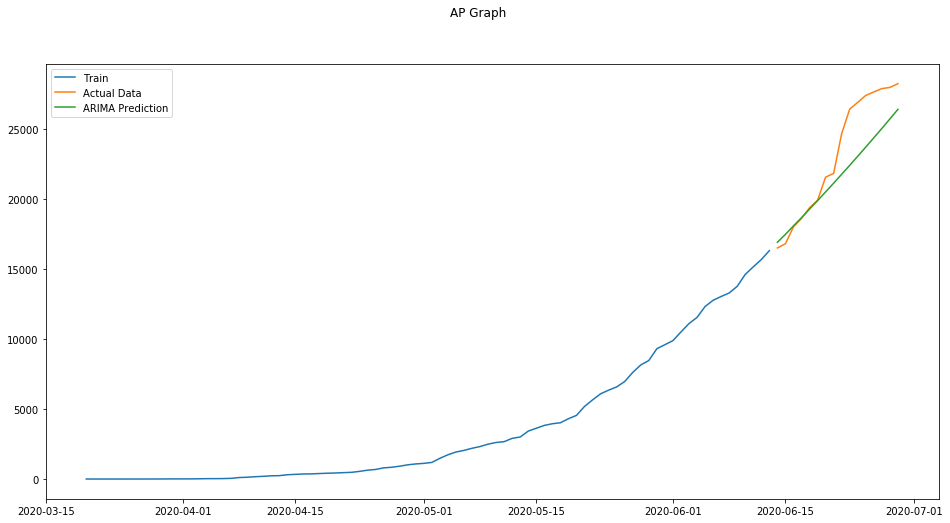

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=873.089, BIC=887.745, Time=0.354 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=881.292, BIC=886.177, Time=0.017 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=882.146, BIC=889.474, Time=0.068 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=879.207, BIC=886.535, Time=0.067 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=879.523, BIC=881.965, Time=0.013 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=868.237, BIC=880.450, Time=0.280 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=866.516, BIC=876.287, Time=0.133 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=868.082, BIC=880.296, Time=0.236 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=869.191, BIC=878.961, Time=0.166 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=869.177, BIC=883.833, Time=0.291 seconds
Total fit time: 1.637 seconds


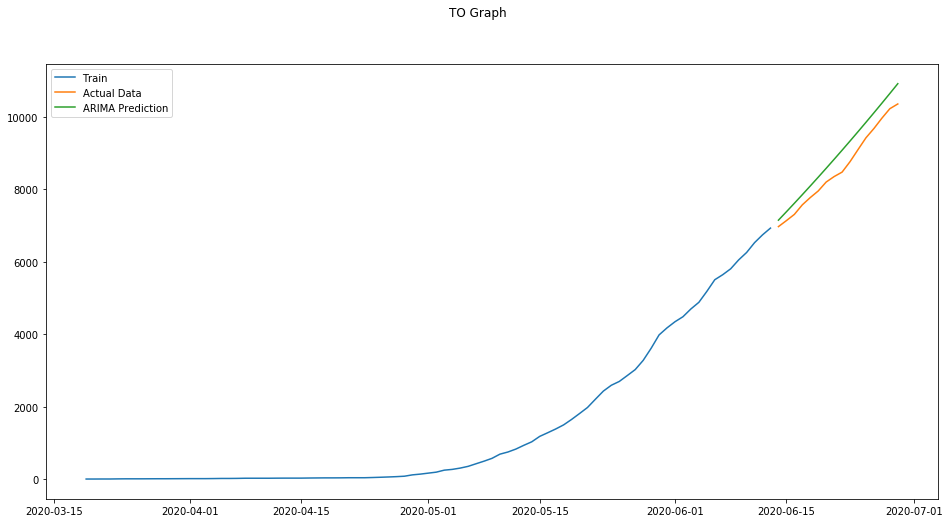

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1198.534, BIC=1213.047, Time=0.312 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1211.668, BIC=1216.505, Time=0.014 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1204.434, BIC=1211.691, Time=0.029 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1200.367, BIC=1207.623, Time=0.109 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1209.822, BIC=1212.241, Time=0.010 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1198.767, BIC=1210.861, Time=0.325 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1200.075, BIC=1212.169, Time=0.374 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1195.687, BIC=1212.619, Time=0.388 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1196.095, BIC

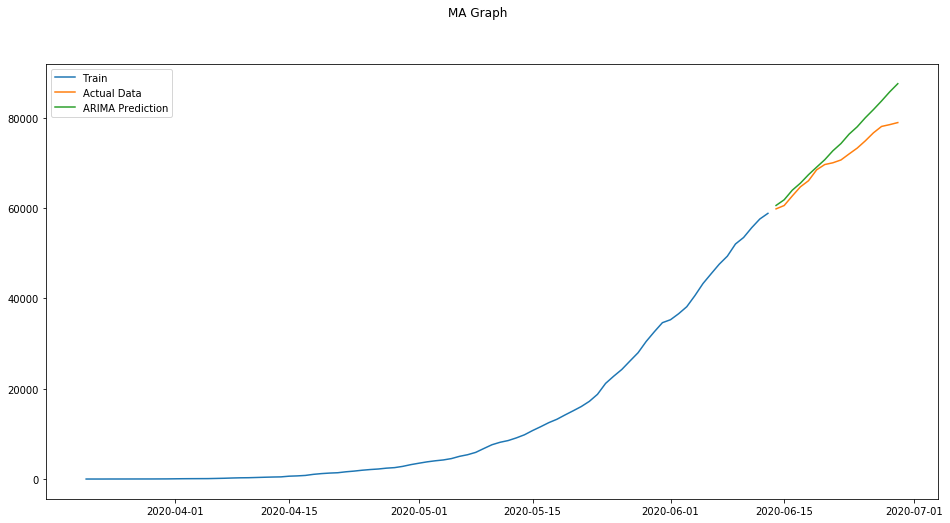

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=945.919, BIC=960.504, Time=0.311 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=966.673, BIC=971.535, Time=0.015 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=956.501, BIC=963.793, Time=0.042 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=943.032, BIC=950.324, Time=0.081 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=965.180, BIC=967.611, Time=0.010 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=943.032, BIC=952.755, Time=0.158 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=944.744, BIC=956.898, Time=0.212 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=945.122, BIC=957.276, Time=0.304 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=942.958, BIC=952.682, Time=0.

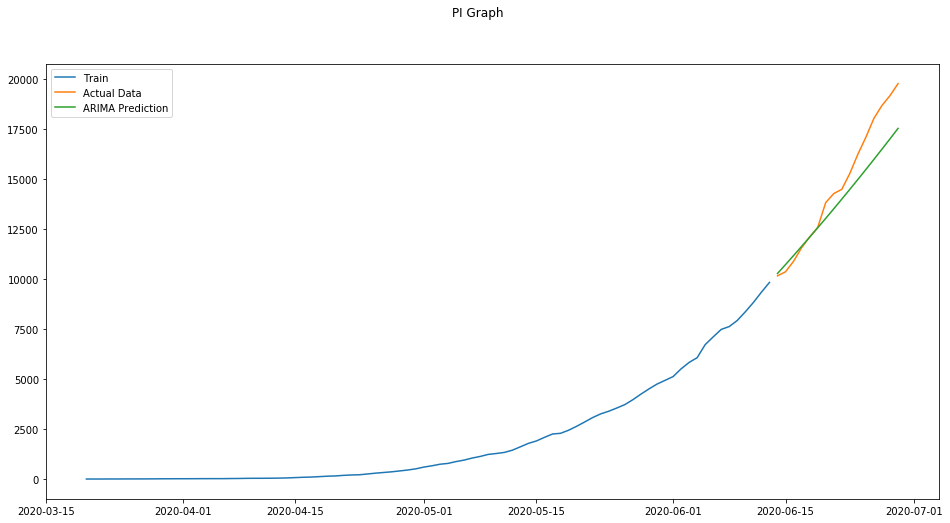

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1451.265, BIC=1466.060, Time=0.501 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1494.444, BIC=1499.376, Time=0.018 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1472.820, BIC=1480.218, Time=0.032 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1445.752, BIC=1453.149, Time=0.117 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1492.447, BIC=1494.913, Time=0.019 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1449.755, BIC=1462.084, Time=0.240 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1449.348, BIC=1461.677, Time=0.422 seco

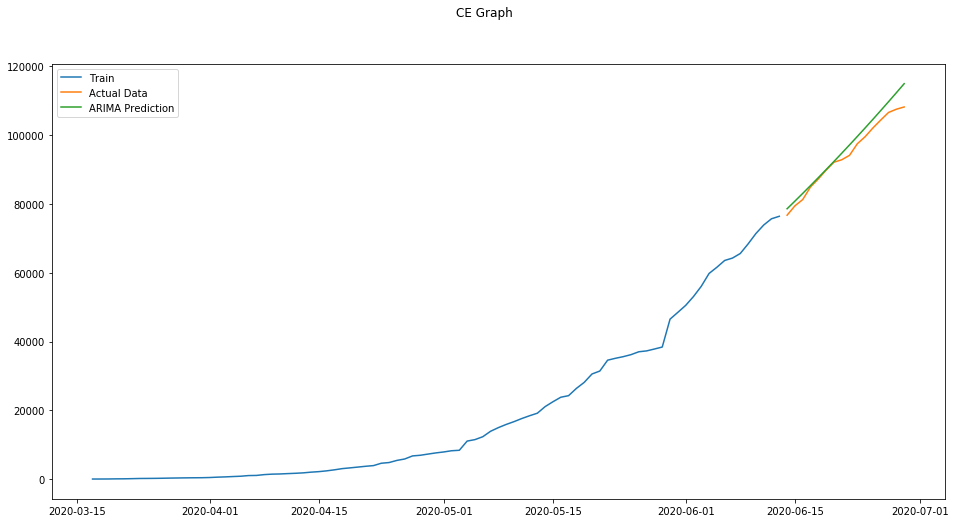

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1254.432, BIC=1269.497, Time=0.337 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1330.010, BIC=1335.032, Time=0.012 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1307.075, BIC=1314.607, Time=0.041 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1264.110, BIC=1271.643, Time=0.126 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1328.018, BIC=1330.529, Time=0.015 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1263.540, BIC=1276.095, Time=0.381 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1257.141, BIC=1269.695, Time=0.308 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1256.703, BIC=1274.279, Time=0.508 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); set

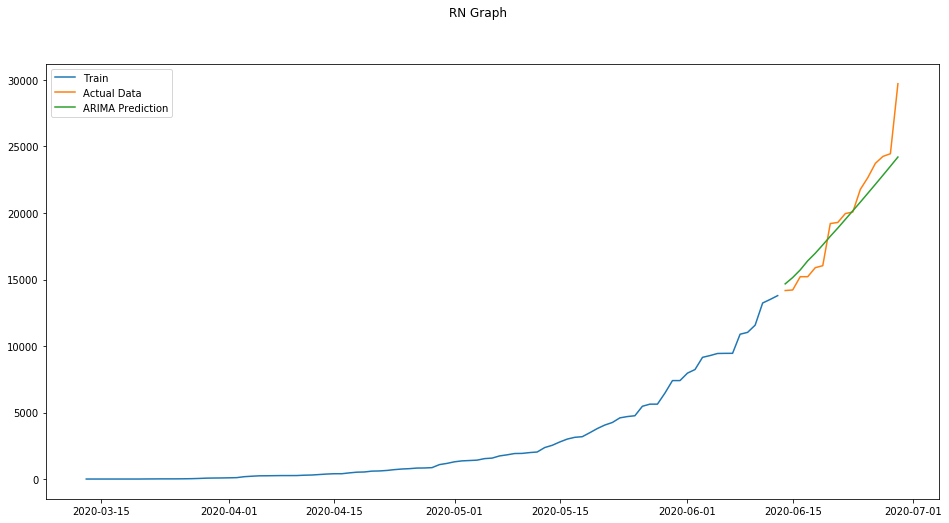

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1146.067, BIC=1160.723, Time=0.337 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1155.911, BIC=1160.796, Time=0.015 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1157.317, BIC=1164.645, Time=0.030 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1151.338, BIC=1158.666, Time=0.088 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1154.121, BIC=1156.564, Time=0.010 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1147.231, BIC=1159.444, Time=0.382 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1135.467, BIC=1147.680, Time=0.623 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1142.082, BIC=1151.853, Time=0.214 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1153.622, BIC

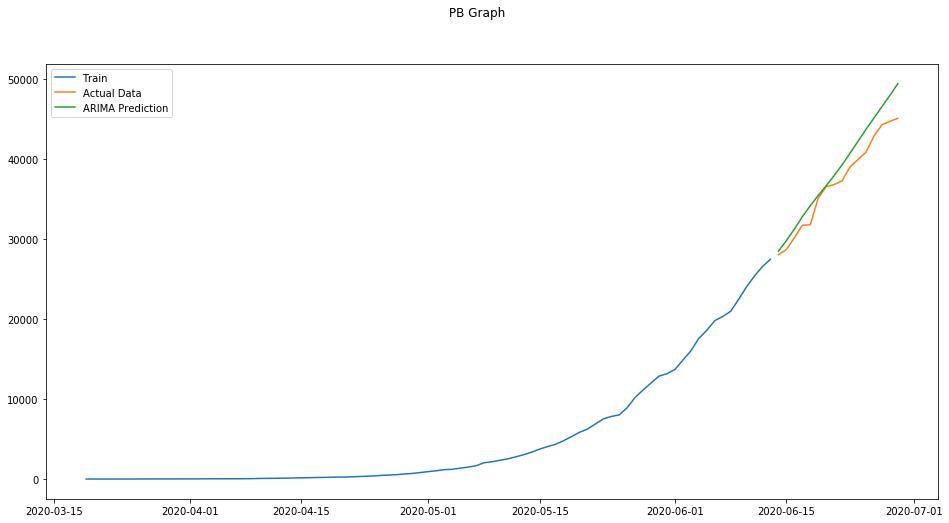

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1299.965, BIC=1315.095, Time=0.446 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1324.674, BIC=1329.718, Time=0.014 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1315.380, BIC=1322.945, Time=0.045 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1298.864, BIC=1306.429, Time=0.163 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1322.743, BIC=1325.265, Time=0.023 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1297.324, BIC=1307.411, Time=0.376 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1298.977, BIC=1311.586, Time=0.402 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1300.337, BIC=1312.946, Time=0.440 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1297.165, BIC=1307.252, Time=0.255 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=1299.128, BIC=1311.737, Time=0.308 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercep

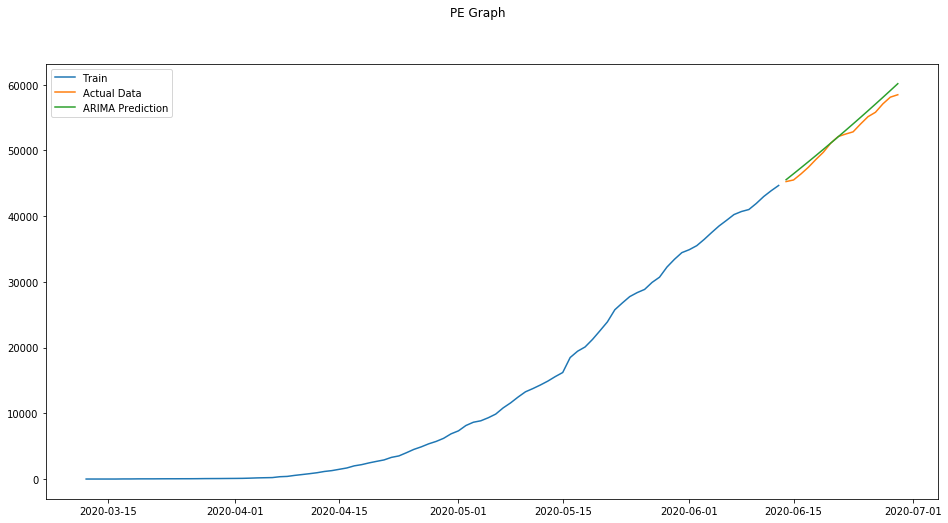

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1232.540, BIC=1247.926, Time=0.330 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1303.909, BIC=1309.038, Time=0.014 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1260.492, BIC=1268.185, Time=0.061 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1239.514, BIC=1247.207, Time=0.110 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1302.081, BIC=1304.645, Time=0.013 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1224.423, BIC=1237.245, Time=0.378 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1228.073, BIC=1238.330, Time=0.252 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1232.755, BIC=1243.013, Time=0.215 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=1228.501, BIC=1243.887, Time=0.331 seconds
Near non-invertible roots for order (1, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the bord

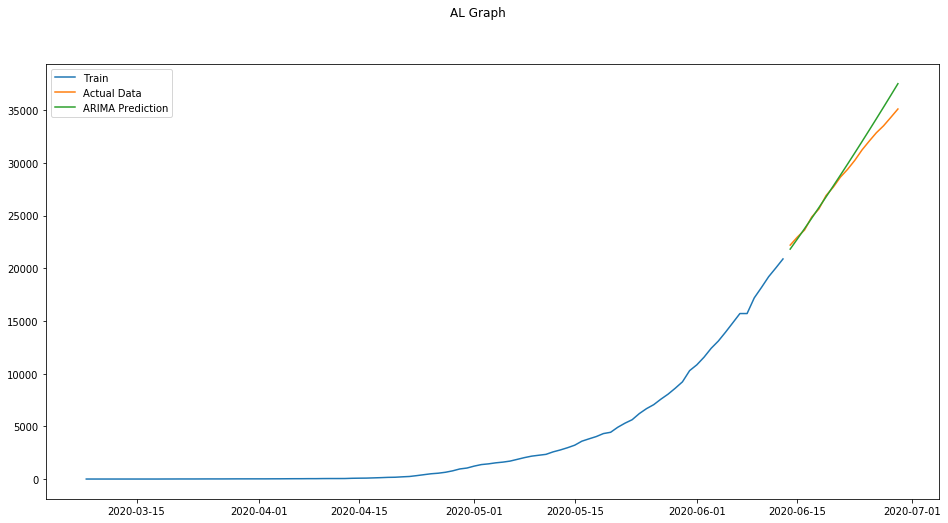

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1098.672, BIC=1113.604, Time=0.363 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1102.621, BIC=1107.598, Time=0.019 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1096.787, BIC=1104.253, Time=0.084 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1094.861, BIC=1102.327, Time=0.121 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1102.091, BIC=1104.580, Time=0.011 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1096.616, BIC=1106.570, Time=0.164 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1096.539, BIC=1106.494, Time=0.190 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1097.435, BIC=1109.878, Time=0.209 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 1.171 seconds


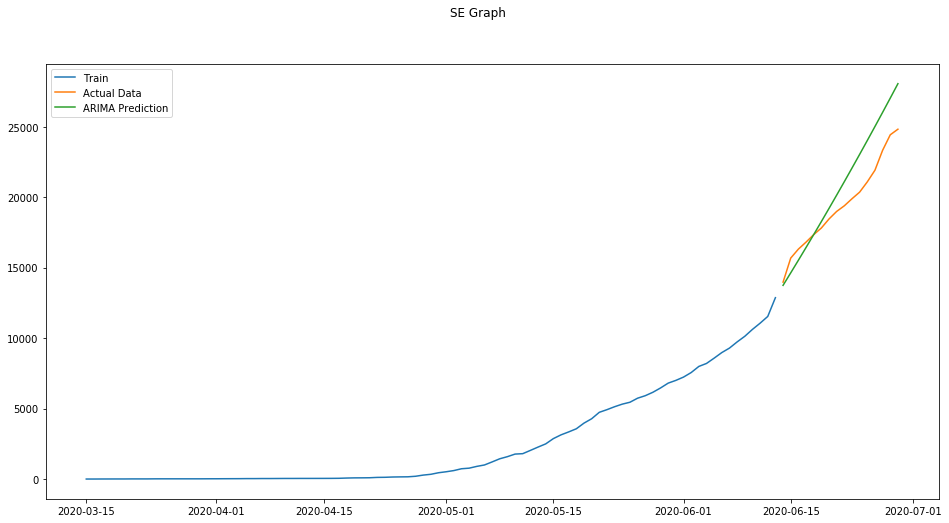

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1458.768, BIC=1474.278, Time=0.443 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1522.156, BIC=1527.326, Time=0.013 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1498.488, BIC=1506.243, Time=0.030 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1459.750, BIC=1467.505, Time=0.119 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1520.197, BIC=1522.782, Time=0.011 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1463.744, BIC=1476.668, Time=0.296 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1458.241, BIC=1471.166, Time=0.458 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1460.598, BIC=1470.937, Time=0.285 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1481.329, BIC

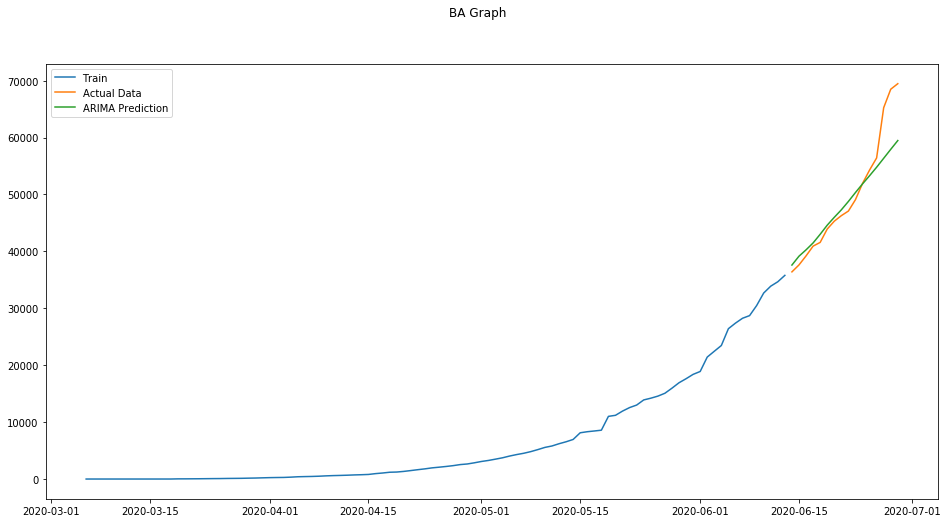

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1293.714, BIC=1309.100, Time=0.322 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1326.030, BIC=1331.159, Time=0.016 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1308.490, BIC=1316.184, Time=0.030 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1288.225, BIC=1295.918, Time=0.104 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1324.078, BIC=1326.643, Time=0.009 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1289.713, BIC=1299.970, Time=0.207 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1289.711, BIC=1299.968, Time=0.207 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1292.173, BIC=1304.994, Time=0.316 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 1.224 seconds


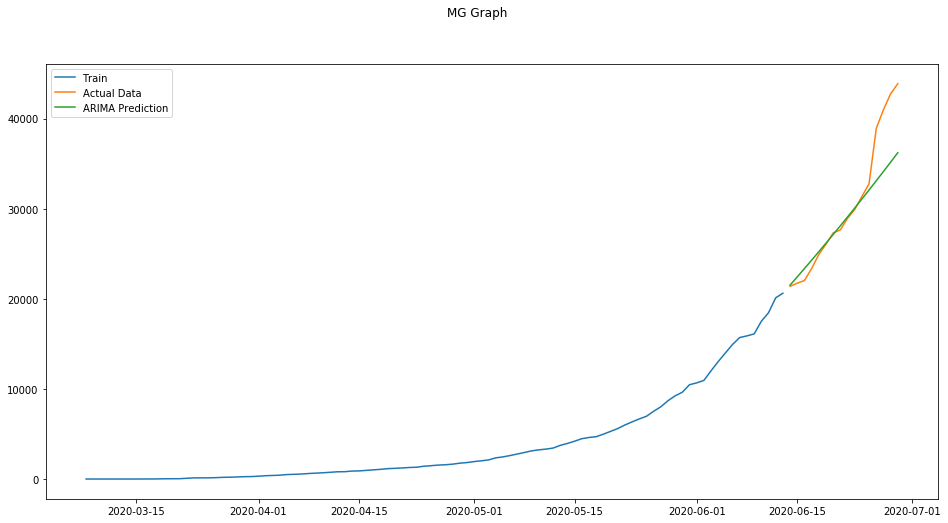

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1257.997, BIC=1273.506, Time=0.285 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1277.773, BIC=1282.943, Time=0.015 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1277.081, BIC=1284.835, Time=0.063 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1267.001, BIC=1274.755, Time=0.097 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1275.953, BIC=1278.538, Time=0.009 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1258.547, BIC=1271.472, Time=0.233 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1257.452, BIC=1270.377, Time=0.320 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1260.222, BIC=1270.562, Time=0.343 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1268.602, BIC

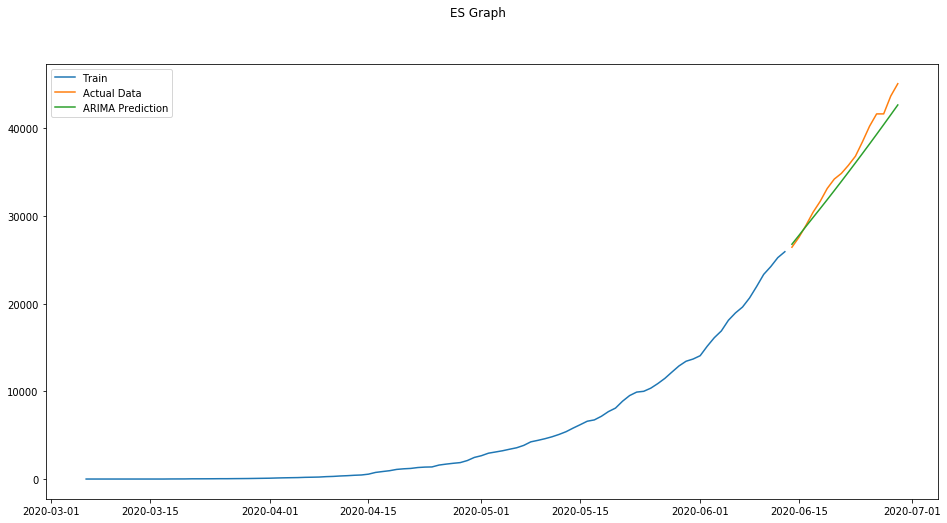

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1571.935, BIC=1587.505, Time=0.572 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1630.457, BIC=1635.647, Time=0.014 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1589.530, BIC=1597.316, Time=0.035 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1569.776, BIC=1577.561, Time=0.121 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1628.471, BIC=1631.066, Time=0.013 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1570.465, BIC=1580.845, Time=0.216 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1570.722, BIC=1581.102, Time=0.219 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1569.859, BIC=1582.834, Time=0.326 seconds
Total fit time: 1.526 seconds


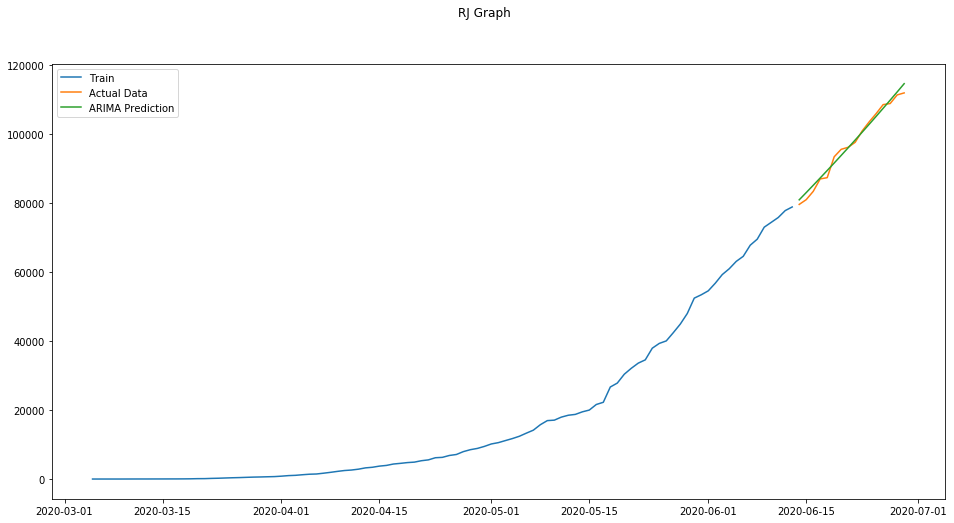

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1765.252, BIC=1781.289, Time=0.543 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1806.603, BIC=1811.949, Time=0.012 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1807.493, BIC=1815.511, Time=0.025 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1792.405, BIC=1800.424, Time=0.142 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1804.794, BIC=1807.466, Time=0.010 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1776.071, BIC=1789.435, Time=0.256 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1771.034, BIC=1784.398, Time=0.361 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1775.121, BIC=1793.830, Time=0.384 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,3)x(0,0,0,0) [intercept=True]; AIC=1770.344, BIC

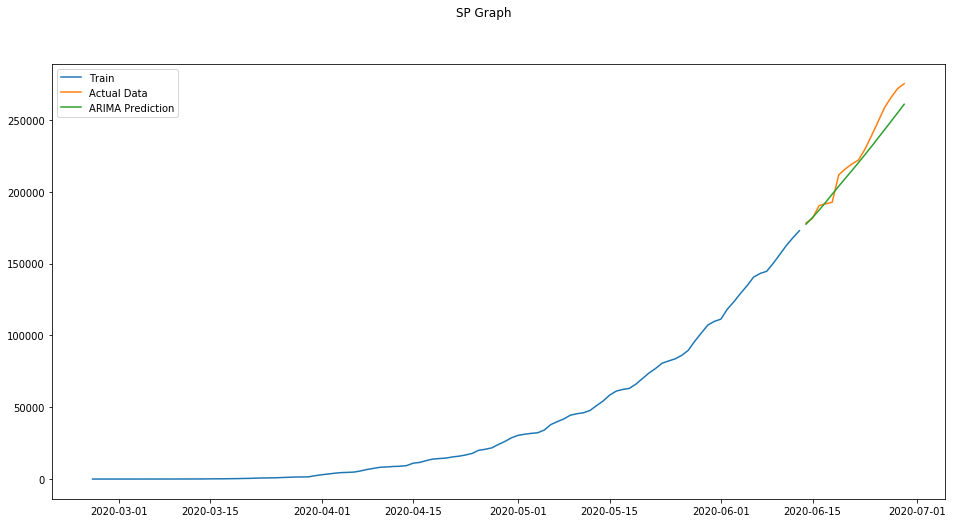

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1038.860, BIC=1053.990, Time=0.365 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1064.002, BIC=1069.046, Time=0.014 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1049.425, BIC=1056.990, Time=0.061 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1033.887, BIC=1041.453, Time=0.072 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1062.514, BIC=1065.036, Time=0.015 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1035.413, BIC=1045.500, Time=0.139 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1035.390, BIC=1045.477, Time=0.160 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1037.242, BIC=1049.851, Time=0.244 seconds
Total fit time: 1.077 seconds


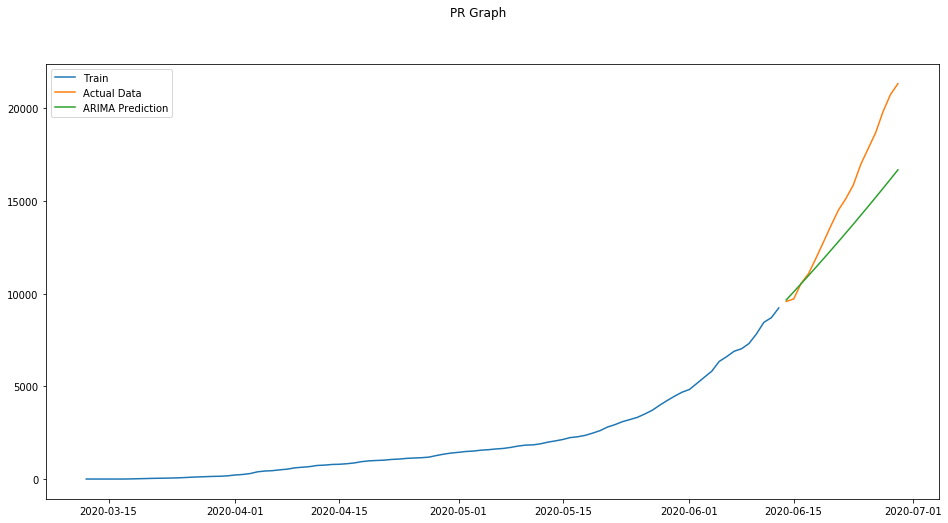

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1155.164, BIC=1170.229, Time=0.335 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1212.026, BIC=1217.048, Time=0.011 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1196.732, BIC=1204.264, Time=0.064 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1155.442, BIC=1162.974, Time=0.108 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1210.031, BIC=1212.542, Time=0.011 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1159.026, BIC=1171.581, Time=0.241 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1155.742, BIC=1168.296, Time=0.219 seco

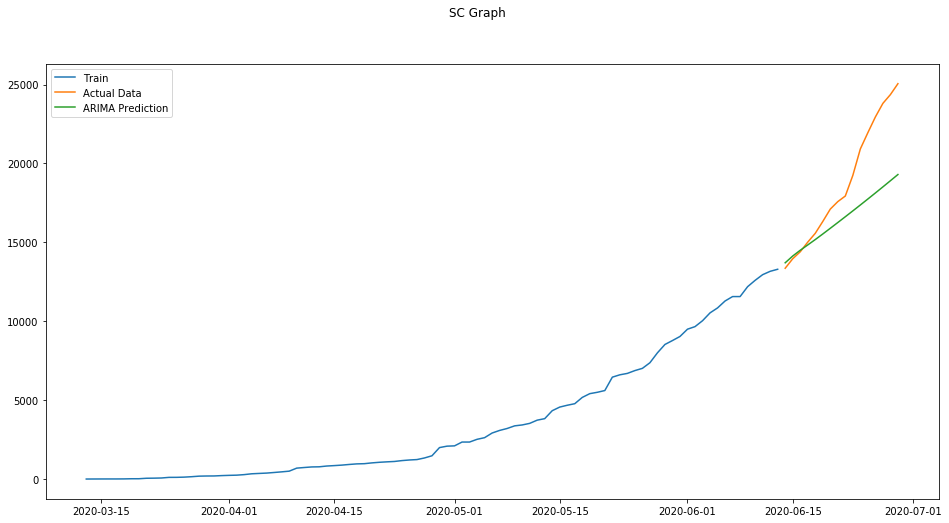

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1284.031, BIC=1299.291, Time=0.399 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1339.225, BIC=1344.312, Time=0.013 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1310.482, BIC=1318.112, Time=0.031 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1278.613, BIC=1286.243, Time=0.091 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1337.232, BIC=1339.776, Time=0.013 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1280.210, BIC=1290.383, Time=0.146 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1280.180, BIC=1290.353, Time=0.198 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1282.270, BIC=1294.986, Time=0.247 seconds
Total fit time: 1.148 seconds


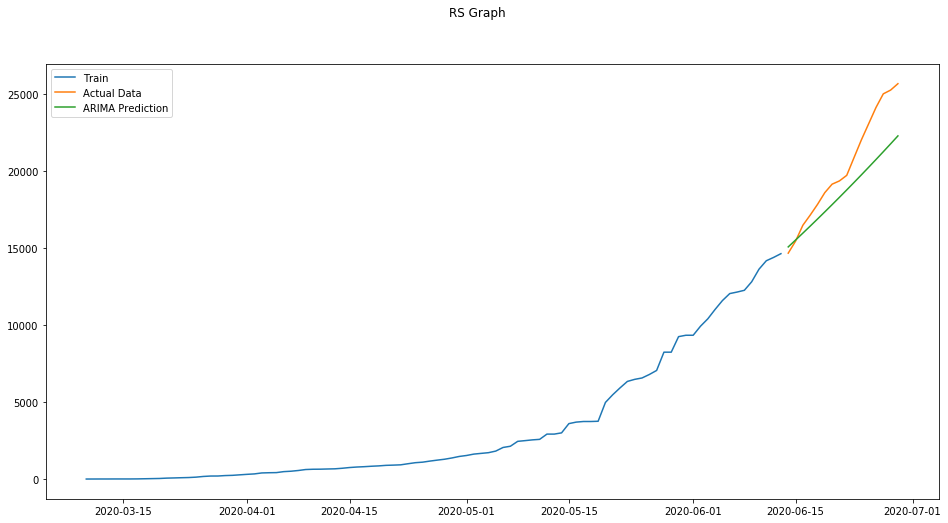

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=799.671, BIC=814.535, Time=0.303 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=827.936, BIC=832.891, Time=0.016 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=798.348, BIC=805.780, Time=0.061 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=796.898, BIC=804.330, Time=0.078 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=826.829, BIC=829.306, Time=0.009 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=796.053, BIC=805.963, Time=0.124 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=797.981, BIC=810.368, Time=0.170 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=797.712, BIC=810.098, Time=0.220 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=796.368, BIC=806.278, Time=0.123 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=797.095, BIC=807.004, Time=0.119 seconds
Total fit time: 1.236 seconds


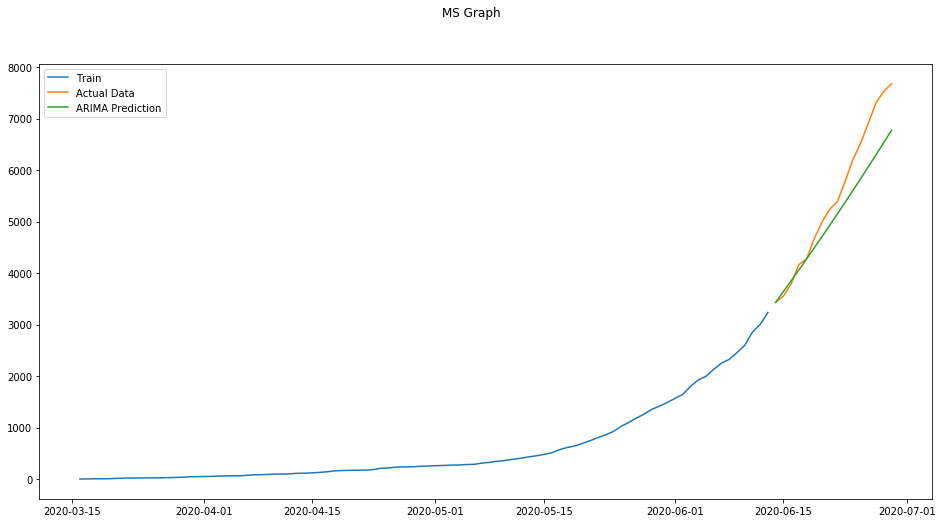

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=888.052, BIC=902.637, Time=0.241 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=924.108, BIC=928.970, Time=0.009 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=918.059, BIC=925.352, Time=0.051 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=895.975, BIC=903.268, Time=0.071 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=922.199, BIC=924.630, Time=0.008 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=891.135, BIC=903.289, Time=0.273 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=896.465, BIC=908.619, Time=0.189 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=890.049, BIC=907.065, Time=0.535 seconds
Fit ARIMA(2,2,3)x(0,0,0,0) [intercept=True]; AIC=876.308, BIC=893.323, Time=0.486 seconds
Near non-invertible roots for order (2, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit cir

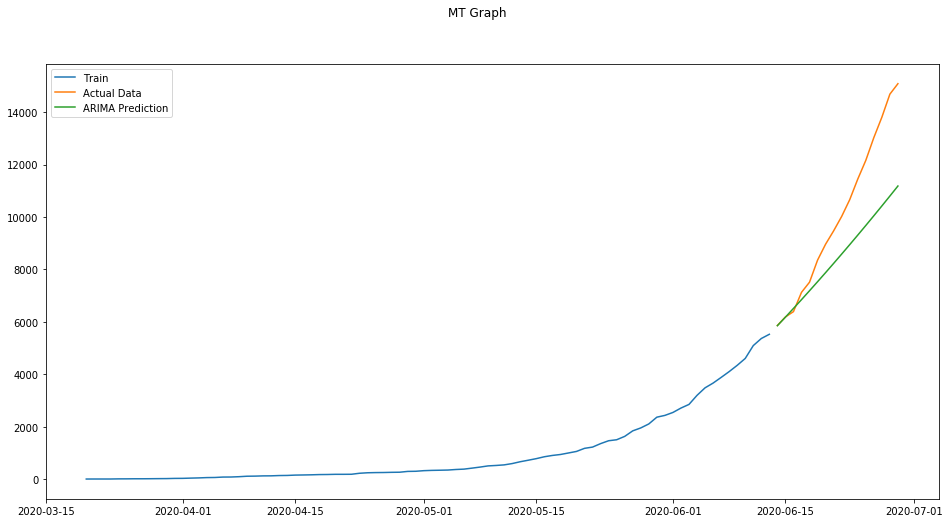

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1030.337, BIC=1045.402, Time=0.432 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1067.591, BIC=1072.613, Time=0.012 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1067.838, BIC=1075.371, Time=0.061 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1058.646, BIC=1066.178, Time=0.063 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1065.605, BIC=1068.116, Time=0.013 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1049.762, BIC=1062.316, Time=0.452 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1045.306, BIC=1057.861, Time=0.250 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1047.258, BIC=1064.834, Time=0.470 seconds
Fit ARIMA(2,2,3)x(0,0,0,0) [intercept=True]; AIC=1045.820, BIC=1063.396, Time=0.477 seconds
Near non-invertible roots for order (2, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the bord

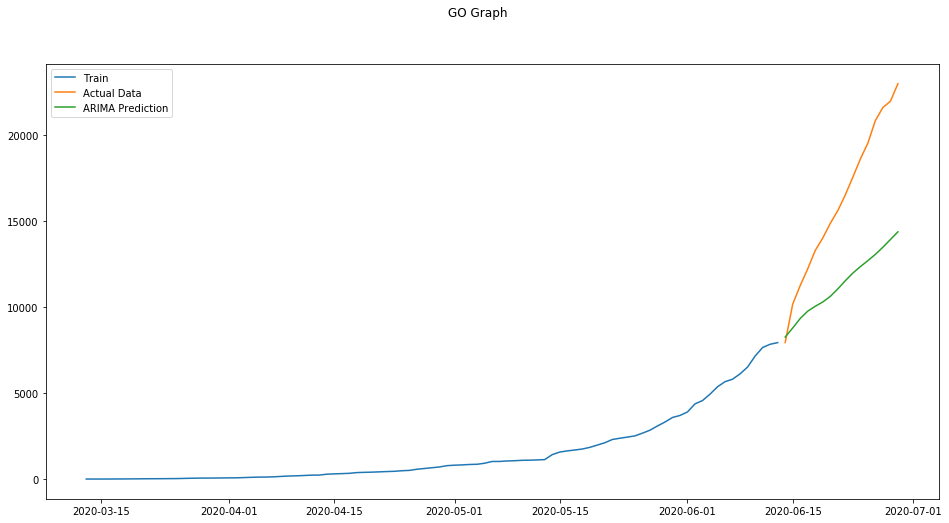

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1280.423, BIC=1295.872, Time=0.340 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1327.141, BIC=1332.290, Time=0.010 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1324.466, BIC=1332.190, Time=0.074 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1299.079, BIC=1306.803, Time=0.102 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1325.207, BIC=1327.782, Time=0.014 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1292.738, BIC=1305.611, Time=0.452 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1285.971, BIC=1298.845, Time=0.226 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1289.991, BIC=1308.014, Time=0.219 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,3)x(0,0,0,0) [intercept=True]; AIC=1279.228, BIC

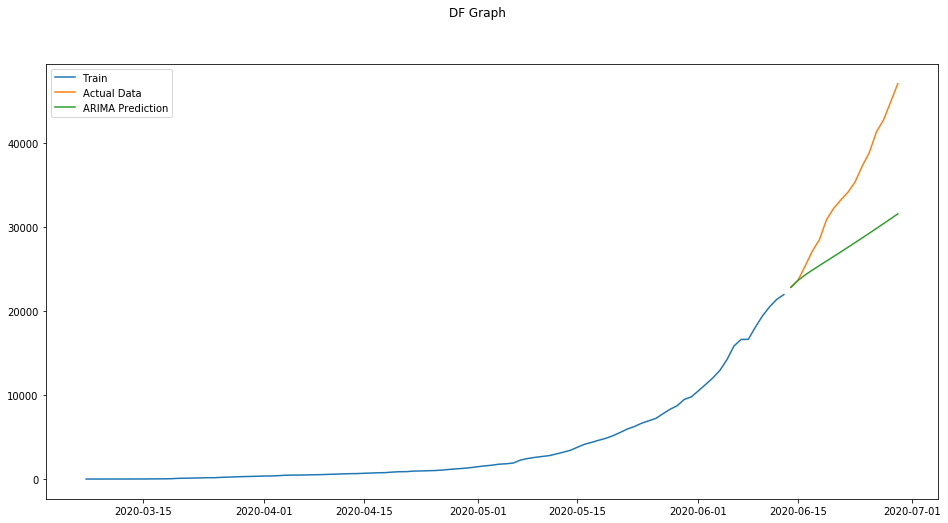

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=2031.430, BIC=2047.467, Time=0.364 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=2056.853, BIC=2062.198, Time=0.010 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=2058.727, BIC=2066.746, Time=0.024 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=2053.842, BIC=2061.861, Time=0.078 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=2055.220, BIC=2057.893, Time=0.011 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=2034.213, BIC=2047.577, Time=0.301 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=2028.032, BIC=2041.396, Time=0.204 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=2041.633, BIC=2052.325, Time=0.173 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=2049.525, BIC=2060.216, Time=0.041 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=2025.748, BIC=2041.785, Time=0.262 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercep

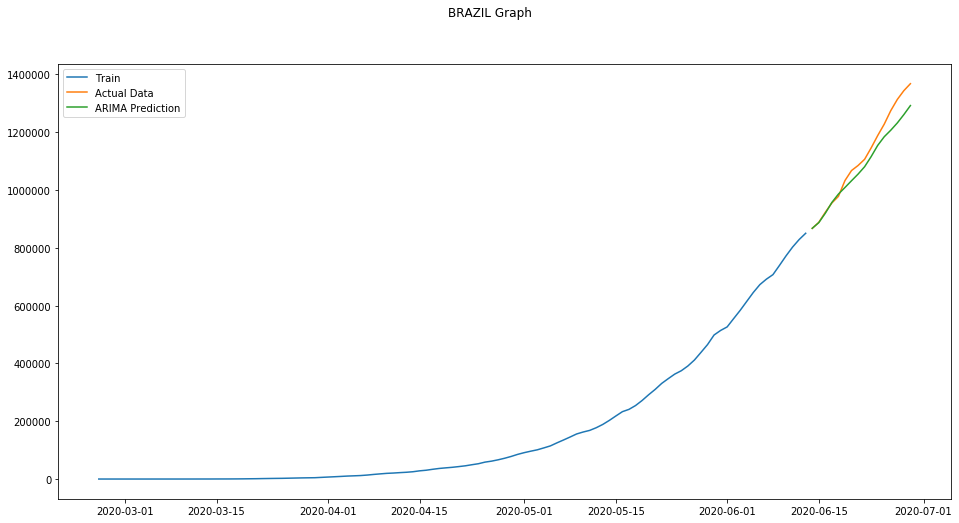

In [150]:
results_df = pd.DataFrame()

states = df["estado"].unique()
states = np.append(states, "BRAZIL") # makes sure it also takes care of Brazil as a whole

for state in states[1:]: # skips over the NAN entry for Brazil
    row = run_test((df), state)
    results_df = results_df.append(row, ignore_index=True)
